<a href="https://colab.research.google.com/github/vit050587/neural_networks/blob/master/KVA_INN_HW_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание TensorFlow

**1 Постройте нейронную сеть (берем несложную полносвязную сеть, меняем число слоев, число нейронов, типы активации, тип оптимизатора) на датасете** *from sklearn.datasets import load_boston.*

**2 Постройте 10-15 вариантов разных нейронных сетей и сведите результаты их работы в таблицу. Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?**

In [ ]:
#!pip install tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# называем mean_squared_error по другому т.к. это же есть и в tensorflow.keras.losses
from sklearn.metrics import mean_squared_error as sklearn_mean_squared_error # <== !!!

import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
import numpy as np

#from sklearn.datasets import load_boston
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, mean_squared_error # <== !!!
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError

# import keras
from keras.callbacks import EarlyStopping
# from keras.layers import Dense
# from keras.models import Sequential
# from keras.utils import to_categorical

# from keras.optimizers import SGD
# from keras.optimizers import Adagrad
# from keras.optimizers import RMSprop
# from keras.optimizers import Adam

print(tf.__version__)

2.12.0


In [6]:
boston_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/neural_networks/lesson03/Boston.csv")
#df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
#df = boston_data['target'] = pd.Series(boston_data.target)
print(boston_data.shape)
boston_data.head()

(506, 15)


,number,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,target
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


**print(boston_data.DESCR)**
* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town
* CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per $10,000

* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV (target)- Median value of owner-occupied homes in $1000's

In [7]:
X = boston_data.drop(['target'], axis=1)
y = boston_data['target']

In [8]:
MinMaxSc = MinMaxScaler()
X_scaled = MinMaxSc.fit_transform(X)

# sc = StandardScaler()
# X_scaled = sc.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state=1)

In [10]:
# создадим пустой датафрейм
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

# 2. 3 слоя, 256 нейронов, ReLU, Adam + Early stoping

**EarlyStopping**: прекращение обучения, когда параметр monitor перестает улучшаться.

**Аргументы**

* monitor: параметр для мониторинга
* min_delta: минимальное значение изменения величины monitor, расцениваемое как улучшение, то есть, если абсолютное изменение меньше min_delta, то улучшение не засчитывается
* patience: число эпох, за которые величина monitor не улучшается, после которых обучение будет остановлено. Проверочные величины могут производиться не после каждой эпохи если validation_freq (model.fit(validation_freq=5)) больше единицы.
* verbose: режим отображения, 0 или 1.
* mode: один из {auto, min, max}. В режиме min, обучение остановится когда величина monitor перестанет уменьшаться; в режиме max, обучение остановится когда величина monitor перестанет увеличиваться; в режиме auto, mode выбирается в зависимости от имени monitor.
* baseline: значение, которое должна достичь величина monitor. Обучение прекратится, если модель не достигла baseline.
* restore_best_weights: восстанавливать ли веса модели с эпохи с лучшем значением параметра monitor. Если False, веса модели будут загружены из последней шага обучения.

In [11]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=100,
                           verbose=1,
                           mode='auto',
                           baseline=None,
                           restore_best_weights=False)

input_layer = Input(shape=(X_train.shape[1],))
dense_layer_1 = Dense(256, activation='relu')(input_layer)
dense_layer_2 = Dense(256, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(256, activation='relu')(dense_layer_2)
output = Dense(1)(dense_layer_3)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

history = model.fit(X_train, y_train, 
                    batch_size=5, 
                    epochs=10, 
                    verbose=0,
                    callbacks=[early_stop],
                    validation_data=(X_test, y_test),
                    #validation_split=0.2
                   )

y_pred_train = model.predict(X_train)
print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict(X_test)
print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

r2_train = round(r2_score(y_train, y_pred_train), 4)
r2_test = round(r2_score(y_test, y_pred_test), 4)

12/12 [==============================] - 0s 2ms/step
3.7748856655447853
4/4 [==============================] - 0s 4ms/step
3.299080500704226


In [12]:
n_neurons = [int(i) for i in np.geomspace(51, 1000, num=10, axis=0).tolist()]
n_neurons

[51, 70, 98, 137, 191, 266, 370, 516, 718, 1000]

# batch size

# 3 слоя, 50-100 нейронов, ReLU, Adam, batch size = 10

In [13]:
# создадим пустой датафрейм
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [14]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    output = Dense(1)(dense_layer_1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=10, 
                        epochs=10, 
                        verbose=0,
                        #callbacks=[early_stop],
                        validation_data=(X_test, y_test),
                        #validation_split=0.2
                       )

    y_pred_train = model.predict(X_train)
    #print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

    y_pred_test = model.predict(X_test)
    #print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [3, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

  0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 1/10 [00:03<00:29,  3.27s/it]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 2/10 [00:05<00:20,  2.51s/it]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 3/10 [00:07<00:15,  2.24s/it]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 4/10 [00:09<00:14,  2.41s/it]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 5/10 [00:12<00:12,  2.49s/it]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 6/10 [00:16<00:12,  3.11s/it]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 7/10 [00:27<00:16,  5.62s/it]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 8/10 [00:33<00:11,  5.73s/it]

4/4 [==============================] - 0s 3ms/step


 90%|█████████ | 9/10 [00:35<00:04,  4.63s/it]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,3,51,ReLu,Adam,-0.3088,-0.2873
1,3,70,ReLu,Adam,-0.1687,-0.1570
2,3,98,ReLu,Adam,-0.0091,-0.0110
3,3,137,ReLu,Adam,0.0907,0.0774
4,3,191,ReLu,Adam,0.2396,0.2209
5,3,266,ReLu,Adam,0.3134,0.2978
6,3,370,ReLu,Adam,0.3773,0.3711
7,3,516,ReLu,Adam,0.4186,0.4386
8,3,718,ReLu,Adam,0.4619,0.4764
9,3,1000,ReLu,Adam,0.4895,0.5100


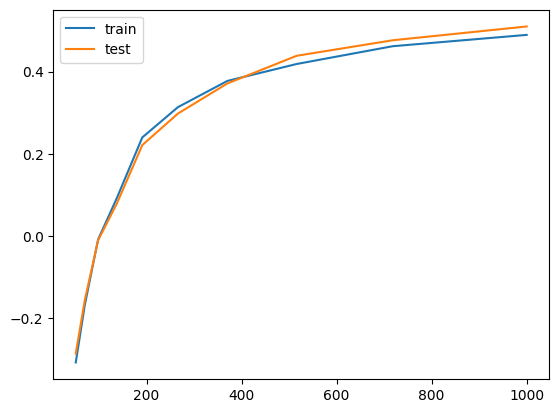

In [15]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

# 3 слоя, 50-100 нейронов, ReLU, Adam, batch size = 5

In [16]:
# создадим пустой датафрейм
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [17]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    output = Dense(1)(dense_layer_1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=5, 
                        epochs=10, 
                        verbose=0,
                        #callbacks=[early_stop],
                        validation_data=(X_test, y_test),
                        #validation_split=0.2
                       )

    y_pred_train = model.predict(X_train)
    #print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

    y_pred_test = model.predict(X_test)
    #print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [3, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

  0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 1/10 [00:03<00:33,  3.68s/it]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 2/10 [00:06<00:27,  3.44s/it]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 3/10 [00:10<00:24,  3.57s/it]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 4/10 [00:14<00:22,  3.81s/it]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 5/10 [00:21<00:23,  4.67s/it]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 6/10 [00:27<00:20,  5.13s/it]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 7/10 [00:31<00:14,  4.94s/it]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 8/10 [00:35<00:09,  4.57s/it]

4/4 [==============================] - 0s 3ms/step


 90%|█████████ | 9/10 [00:41<00:05,  5.03s/it]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 10/10 [00:47<00:00,  4.75s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,3,51,ReLu,Adam,0.2555,0.2467
1,3,70,ReLu,Adam,0.3669,0.3679
2,3,98,ReLu,Adam,0.3754,0.3757
3,3,137,ReLu,Adam,0.4151,0.4177
4,3,191,ReLu,Adam,0.4921,0.5124
5,3,266,ReLu,Adam,0.5059,0.5327
6,3,370,ReLu,Adam,0.5439,0.5821
7,3,516,ReLu,Adam,0.5476,0.6055
8,3,718,ReLu,Adam,0.6288,0.6881
9,3,1000,ReLu,Adam,0.6399,0.6969


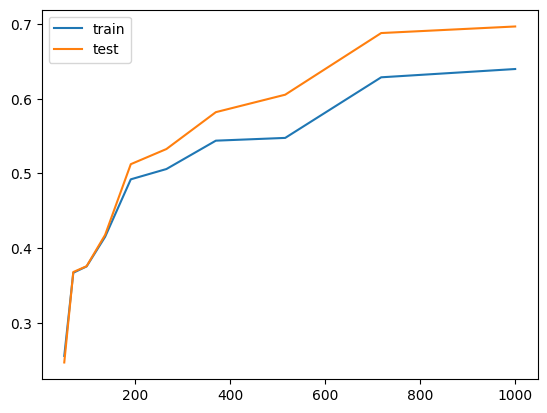

In [18]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

# 3 слоя, 50-100 нейронов, ReLU, Adam, batch size = 1

In [19]:
# создадим пустой датафрейм
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [20]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    output = Dense(1)(dense_layer_1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        #callbacks=[early_stop],
                        validation_data=(X_test, y_test),
                        #validation_split=0.2
                       )

    y_pred_train = model.predict(X_train)
    #print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

    y_pred_test = model.predict(X_test)
    #print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [3, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

  0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 1/10 [00:11<01:39, 11.10s/it]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 2/10 [00:32<02:17, 17.18s/it]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 3/10 [00:45<01:46, 15.19s/it]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 4/10 [01:06<01:45, 17.62s/it]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 5/10 [01:14<01:11, 14.24s/it]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 6/10 [01:26<00:52, 13.17s/it]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 7/10 [01:37<00:37, 12.50s/it]

4/4 [==============================] - 0s 6ms/step


 80%|████████  | 8/10 [01:46<00:23, 11.61s/it]

4/4 [==============================] - 0s 3ms/step


 90%|█████████ | 9/10 [01:58<00:11, 11.60s/it]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 10/10 [02:09<00:00, 12.97s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,3,51,ReLu,Adam,0.5798,0.6356
1,3,70,ReLu,Adam,0.6096,0.6662
2,3,98,ReLu,Adam,0.6240,0.6915
3,3,137,ReLu,Adam,0.6574,0.7354
4,3,191,ReLu,Adam,0.6570,0.7530
5,3,266,ReLu,Adam,0.6891,0.7734
6,3,370,ReLu,Adam,0.6125,0.7300
7,3,516,ReLu,Adam,0.6754,0.7596
8,3,718,ReLu,Adam,0.7320,0.8190
9,3,1000,ReLu,Adam,0.7424,0.8300


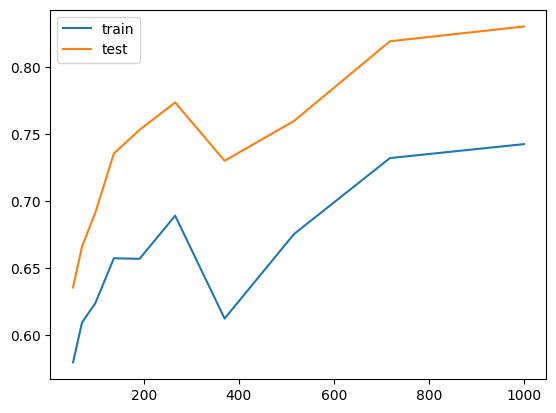

In [21]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

**Вывод**:
Уменьшение батча ускоряет обучение модели.

Дальше будем обучать модели с batch_size = 1

# Количество слоёв

# 3 слоя, 50-100 нейронов, ReLU, Adam

In [22]:
# создадим пустой датафрейм
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [23]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    output = Dense(1)(dense_layer_1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        #callbacks=[early_stop],
                        validation_data=(X_test, y_test),
                        #validation_split=0.2
                       )

    y_pred_train = model.predict(X_train)
    #print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

    y_pred_test = model.predict(X_test)
    #print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [3, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

  0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 1/10 [00:09<01:28,  9.81s/it]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 2/10 [00:21<01:27, 10.91s/it]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 3/10 [00:32<01:17, 11.11s/it]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 4/10 [00:41<01:01, 10.20s/it]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 5/10 [01:03<01:11, 14.27s/it]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 6/10 [01:14<00:53, 13.27s/it]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 7/10 [01:28<00:40, 13.39s/it]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 8/10 [01:39<00:25, 12.68s/it]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 9/10 [01:51<00:12, 12.49s/it]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 10/10 [02:01<00:00, 12.16s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,3,51,ReLu,Adam,0.5941,0.6497
1,3,70,ReLu,Adam,0.6429,0.7080
2,3,98,ReLu,Adam,0.6378,0.7049
3,3,137,ReLu,Adam,0.6374,0.7139
4,3,191,ReLu,Adam,0.6674,0.7450
5,3,266,ReLu,Adam,0.6717,0.7647
6,3,370,ReLu,Adam,0.7092,0.7994
7,3,516,ReLu,Adam,0.6514,0.7629
8,3,718,ReLu,Adam,0.7197,0.8034
9,3,1000,ReLu,Adam,0.7113,0.8061


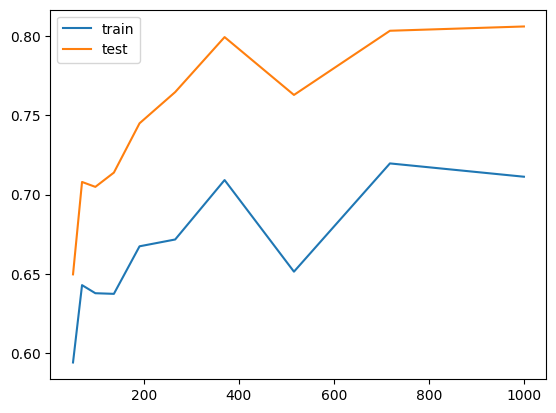

In [24]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

# 4 слоя, 50-100 нейронов, ReLU, Adam

In [25]:
# создадим пустой датафрейм
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [26]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    dense_layer_2 = Dense(n_neuron, activation='relu')(dense_layer_1)
    output = Dense(1)(dense_layer_2)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        #callbacks=[early_stop],
                        validation_data=(X_test, y_test),
                        #validation_split=0.2
                       )

    y_pred_train = model.predict(X_train)
    #print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

    y_pred_test = model.predict(X_test)
    #print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [4, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

  0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 1/10 [00:09<01:24,  9.40s/it]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 2/10 [00:19<01:19,  9.98s/it]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 3/10 [00:32<01:19, 11.32s/it]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 4/10 [00:44<01:08, 11.39s/it]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 5/10 [00:54<00:55, 11.08s/it]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 6/10 [01:07<00:46, 11.51s/it]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 7/10 [01:24<00:40, 13.52s/it]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 8/10 [01:50<00:35, 17.56s/it]

4/4 [==============================] - 0s 6ms/step


 90%|█████████ | 9/10 [02:24<00:22, 22.52s/it]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 10/10 [03:26<00:00, 20.66s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,4,51,ReLu,Adam,0.7106,0.7962
1,4,70,ReLu,Adam,0.7419,0.8191
2,4,98,ReLu,Adam,0.7564,0.8459
3,4,137,ReLu,Adam,0.7780,0.8615
4,4,191,ReLu,Adam,0.7870,0.8586
5,4,266,ReLu,Adam,0.7325,0.8183
6,4,370,ReLu,Adam,0.8286,0.8812
7,4,516,ReLu,Adam,0.8013,0.8670
8,4,718,ReLu,Adam,0.8562,0.9114
9,4,1000,ReLu,Adam,0.8530,0.9064


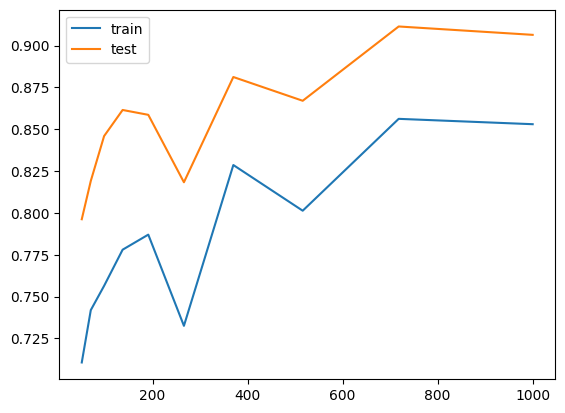

In [27]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

# 5 слоёв, 50-100 нейронов, ReLU, Adam

In [28]:
# создадим пустой датафрейм
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [29]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    dense_layer_2 = Dense(n_neuron, activation='relu')(dense_layer_1)
    dense_layer_3 = Dense(n_neuron, activation='relu')(dense_layer_2)
    output = Dense(1)(dense_layer_3)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        #callbacks=[early_stop],
                        validation_data=(X_test, y_test),
                        #validation_split=0.2
                       )

    y_pred_train = model.predict(X_train)
    #print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

    y_pred_test = model.predict(X_test)
    #print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [5, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

  0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 1/10 [00:09<01:28,  9.84s/it]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 2/10 [00:21<01:26, 10.77s/it]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 3/10 [00:29<01:07,  9.60s/it]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 4/10 [00:41<01:03, 10.65s/it]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 5/10 [00:53<00:54, 10.91s/it]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 6/10 [01:06<00:46, 11.68s/it]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 7/10 [01:28<00:45, 15.03s/it]

4/4 [==============================] - 0s 8ms/step


 80%|████████  | 8/10 [01:56<00:38, 19.41s/it]

4/4 [==============================] - 0s 6ms/step


 90%|█████████ | 9/10 [03:20<00:39, 39.52s/it]

4/4 [==============================] - 0s 8ms/step


100%|██████████| 10/10 [04:57<00:00, 29.73s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,5,51,ReLu,Adam,0.8076,0.8668
1,5,70,ReLu,Adam,0.7813,0.8546
2,5,98,ReLu,Adam,0.7286,0.7866
3,5,137,ReLu,Adam,0.8317,0.8764
4,5,191,ReLu,Adam,0.8288,0.8609
5,5,266,ReLu,Adam,0.7873,0.8427
6,5,370,ReLu,Adam,0.8117,0.8614
7,5,516,ReLu,Adam,0.7927,0.8277
8,5,718,ReLu,Adam,0.8468,0.8794
9,5,1000,ReLu,Adam,0.8099,0.8451


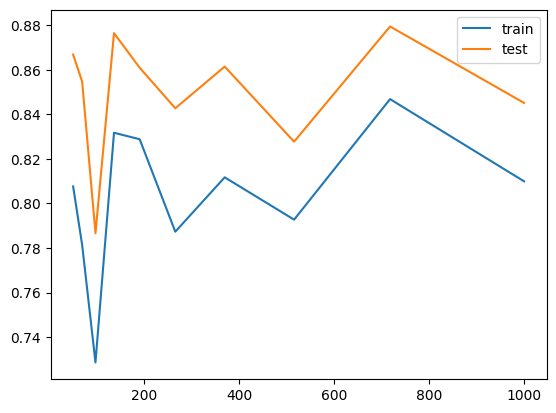

In [30]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

# 6 слоёв, 50-100 нейронов, ReLU, Adam

In [31]:
# создадим пустой датафрейм
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [32]:
for n_neuron in tqdm(n_neurons, leave=False):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    dense_layer_2 = Dense(n_neuron, activation='relu')(dense_layer_1)
    dense_layer_3 = Dense(n_neuron, activation='relu')(dense_layer_2)
    dense_layer_4 = Dense(n_neuron, activation='relu')(dense_layer_3)
    output = Dense(1)(dense_layer_4)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        #callbacks=[early_stop],
                        validation_data=(X_test, y_test),
                        #validation_split=0.2
                       )

    y_pred_train = model.predict(X_train)
    #print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

    y_pred_test = model.predict(X_test)
    #print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [6, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

  0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 1/10 [00:09<01:21,  9.07s/it]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 2/10 [00:18<01:14,  9.35s/it]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 3/10 [00:31<01:17, 11.13s/it]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 4/10 [00:43<01:08, 11.44s/it]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 5/10 [00:58<01:02, 12.54s/it]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 6/10 [01:14<00:55, 13.89s/it]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 7/10 [01:44<00:57, 19.07s/it]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 8/10 [02:26<00:52, 26.21s/it]

4/4 [==============================] - 0s 6ms/step


 90%|█████████ | 9/10 [03:32<00:38, 38.69s/it]

4/4 [==============================] - 0s 12ms/step


,No. layers,No. neurons,act_func,opt,train,test
0,6,51,ReLu,Adam,0.7826,0.8526
1,6,70,ReLu,Adam,0.8420,0.8860
2,6,98,ReLu,Adam,0.8177,0.8836
3,6,137,ReLu,Adam,0.8660,0.8992
4,6,191,ReLu,Adam,0.8350,0.8616
5,6,266,ReLu,Adam,0.4930,0.5756
6,6,370,ReLu,Adam,0.8620,0.8827
7,6,516,ReLu,Adam,0.8498,0.8861
8,6,718,ReLu,Adam,0.8245,0.8457
9,6,1000,ReLu,Adam,0.7979,0.8480


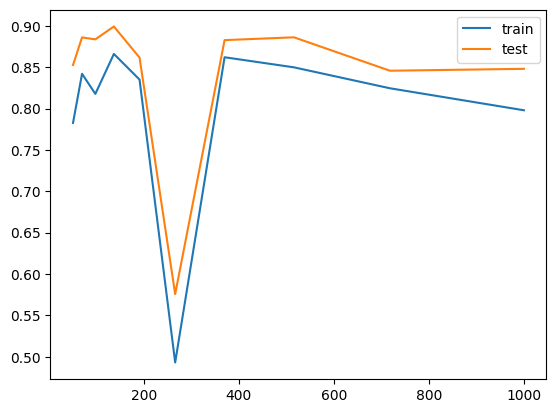

In [33]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

# 7 слоёв, 50-100 нейронов, ReLU, Adam

In [34]:
# создадим пустой датафрейм
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [35]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    dense_layer_2 = Dense(n_neuron, activation='relu')(dense_layer_1)
    dense_layer_3 = Dense(n_neuron, activation='relu')(dense_layer_2)
    dense_layer_4 = Dense(n_neuron, activation='relu')(dense_layer_3)
    dense_layer_5 = Dense(n_neuron, activation='relu')(dense_layer_4)
    output = Dense(1)(dense_layer_5)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        #callbacks=[early_stop],
                        validation_data=(X_test, y_test),
                        #validation_split=0.2
                       )

    y_pred_train = model.predict(X_train)
    #print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

    y_pred_test = model.predict(X_test)
    #print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [7, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

  0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 1/10 [00:12<01:52, 12.45s/it]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 2/10 [00:24<01:36, 12.06s/it]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 3/10 [00:35<01:22, 11.74s/it]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 4/10 [00:47<01:10, 11.74s/it]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 5/10 [01:10<01:19, 15.85s/it]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 6/10 [01:30<01:09, 17.26s/it]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 7/10 [02:13<01:16, 25.53s/it]

4/4 [==============================] - 0s 6ms/step


 80%|████████  | 8/10 [03:36<01:28, 44.01s/it]

4/4 [==============================] - 0s 8ms/step


 90%|█████████ | 9/10 [06:00<01:15, 75.21s/it]

4/4 [==============================] - 0s 19ms/step


100%|██████████| 10/10 [08:39<00:00, 51.96s/it] 


,No. layers,No. neurons,act_func,opt,train,test
0,7,51,ReLu,Adam,0.8092,0.8851
1,7,70,ReLu,Adam,0.8274,0.8886
2,7,98,ReLu,Adam,0.7530,0.8250
3,7,137,ReLu,Adam,0.6363,0.6998
4,7,191,ReLu,Adam,0.8040,0.8216
5,7,266,ReLu,Adam,0.8535,0.8913
6,7,370,ReLu,Adam,0.0605,0.0749
7,7,516,ReLu,Adam,0.7709,0.8128
8,7,718,ReLu,Adam,0.8584,0.8798
9,7,1000,ReLu,Adam,0.8233,0.8847


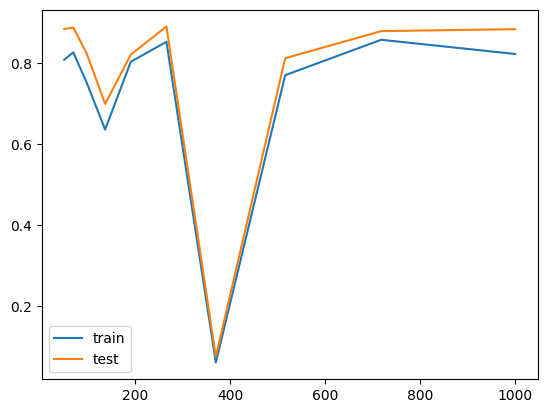

In [36]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

# 9 слоёв, 50-100 нейронов, ReLU, Adam

In [37]:
# создадим пустой датафрейм
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [38]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    dense_layer_2 = Dense(n_neuron, activation='relu')(dense_layer_1)
    dense_layer_3 = Dense(n_neuron, activation='relu')(dense_layer_2)
    dense_layer_4 = Dense(n_neuron, activation='relu')(dense_layer_3)
    dense_layer_5 = Dense(n_neuron, activation='relu')(dense_layer_4)
    dense_layer_6 = Dense(n_neuron, activation='relu')(dense_layer_5)
    dense_layer_7 = Dense(n_neuron, activation='relu')(dense_layer_6)
    output = Dense(1)(dense_layer_7)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        #callbacks=[early_stop],
                        validation_data=(X_test, y_test),
                        #validation_split=0.2
                       )

    y_pred_train = model.predict(X_train)
    #print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

    y_pred_test = model.predict(X_test)
    #print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [9, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

  0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 1/10 [00:10<01:37, 10.86s/it]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 2/10 [00:22<01:32, 11.53s/it]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 3/10 [00:37<01:29, 12.84s/it]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 4/10 [00:59<01:40, 16.69s/it]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 5/10 [01:17<01:24, 16.89s/it]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 6/10 [01:43<01:20, 20.15s/it]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 7/10 [02:27<01:23, 27.96s/it]

4/4 [==============================] - 0s 8ms/step


 80%|████████  | 8/10 [03:51<01:31, 45.76s/it]

4/4 [==============================] - 0s 16ms/step


 90%|█████████ | 9/10 [06:16<01:16, 76.68s/it]

4/4 [==============================] - 0s 22ms/step


100%|██████████| 10/10 [11:40<00:00, 70.06s/it] 


,No. layers,No. neurons,act_func,opt,train,test
0,9,51,ReLu,Adam,0.8398,0.9016
1,9,70,ReLu,Adam,0.7924,0.8343
2,9,98,ReLu,Adam,0.8587,0.8999
3,9,137,ReLu,Adam,0.8241,0.8594
4,9,191,ReLu,Adam,0.5758,0.6321
5,9,266,ReLu,Adam,0.8645,0.9068
6,9,370,ReLu,Adam,0.8106,0.8099
7,9,516,ReLu,Adam,0.8474,0.8958
8,9,718,ReLu,Adam,0.7865,0.8529
9,9,1000,ReLu,Adam,0.7335,0.8050


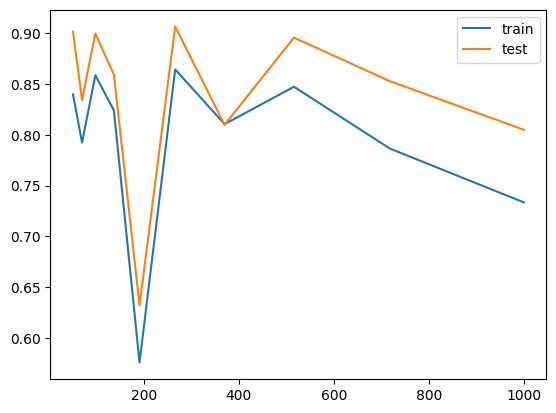

In [39]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

**Вывод**:
Оптимальное количество слоёв 4. При 3-х модель недообучается. Начиная с 5-ти метрики начинают снижаться и обучение становится нестабильным.

Возмём модель с 4-я слоями и батчем = 1 и наилучшим количеством нейронов для этой комбинации, равным 400.

# Финальная модель

4 слоя, батч = 1

In [40]:
# создадим пустой датафрейм
df = pd.DataFrame(columns=['No. layers', 'epoches', 'act_func', 'opt', 'train', 'test'])
i = 0

In [41]:
for epoch in tqdm([10, 50, 100, 200, 500]):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(400, activation='relu')(input_layer)
    dense_layer_2 = Dense(400, activation='relu')(dense_layer_1)
    output = Dense(1)(dense_layer_2)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=epoch, 
                        verbose=0,
                        #callbacks=[early_stop],
                        validation_data=(X_test, y_test),
                        #validation_split=0.2
                       )

    y_pred_train = model.predict(X_train)
    #print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

    y_pred_test = model.predict(X_test)
    #print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [4, epoch, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

  0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 1/5 [00:21<01:27, 21.97s/it]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 2/5 [01:45<02:54, 58.25s/it]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 3/5 [04:23<03:27, 103.61s/it]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 4/5 [09:46<03:10, 190.43s/it]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 5/5 [23:09<00:00, 277.95s/it]


,No. layers,epoches,act_func,opt,train,test
0,4,10,ReLu,Adam,0.7507,0.8248
1,4,50,ReLu,Adam,0.9375,0.8989
2,4,100,ReLu,Adam,0.9485,0.9190
3,4,200,ReLu,Adam,0.9706,0.8980
4,4,500,ReLu,Adam,0.9884,0.9196


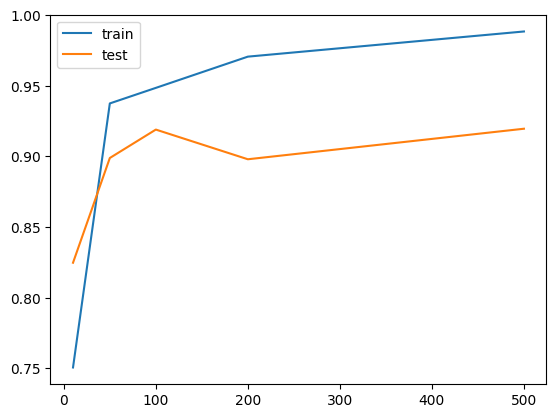

In [42]:
plt.plot(df['epoches'], df['train'], label='train')
plt.plot(df['epoches'], df['test'], label='test')
plt.legend();

**Вывод**:
количество эпох не должно быть большим. Рост эпох увеличивает переобученность модели.

Получить наилучшую модель позволило нахождение оптимальных параметров для:

* батча
* числа эпох
* числа слоёв

**В итоге лучшая модель с наибольшими скорами и без переобучения для этого датасета: 4 слоя, 1 батч и 50 эпох.**

Подбор наилучшего оптимизатора не производился т.к. почти всегда лучшие результаты показывает Адам.